In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import qstock as qs

import talib

import cvxopt as opt
from cvxopt import blas,solvers
solvers.options['show_progress'] = False #solvers will only output result, without process
from scipy.optimize import minimize

import cvxpy as cp
import mysql.connector
import scipy.optimize as sco
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

In [2]:
df = pd.read_csv('tickers.csv')
code_lists = df["codes"].tolist()

In [3]:
import yfinance as yf

In [4]:
multi_data = yf.download(code_lists, start="2021-01-01", end="2024-01-01")
print(multi_data)

[******                13%%                      ]  348 of 2762 completedFailed to get ticker 'IPOC' reason: HTTPSConnectionPool(host='www.yahoo.com', port=443): Read timed out.
[*******               14%%                      ]  386 of 2762 completedFailed to get ticker 'CTEK' reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[**************        30%%                      ]  839 of 2762 completedFailed to get ticker 'GRAF' reason: HTTPSConnectionPool(host='www.yahoo.com', port=443): Read timed out. (read timeout=30)
[***************       32%%                      ]  876 of 2762 completedFailed to get ticker 'TLRD' reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[***************       32%%                      ]  877 of 2762 completedFailed to get ticker 'RPAI' reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[*****************  

Price        Adj Close                                                     \
Ticker               A         AA  AAMC        AAN         AAP        AAT   
Date                                                                        
2021-01-04  118.001701  22.675421   NaN  18.688023  154.917297  23.551785   
2021-01-05  118.966484  23.085039   NaN  19.443094  154.749908  23.766750   
2021-01-06  122.228828  24.586977   NaN  20.714794  163.690094  24.695412   
2021-01-07  125.481255  24.606485   NaN  21.231422  165.088226  24.231081   
2021-01-08  126.376396  24.372419   NaN  20.059074  167.441437  24.265474   
...                ...        ...   ...        ...         ...        ...   
2023-12-22  139.570007  33.647999  4.35  11.110000   61.250000  22.299202   
2023-12-26  139.809998  33.747639  4.21  11.190000   60.919998  22.683163   
2023-12-27  139.820007  34.684242  4.53  11.180000   61.560001  22.515797   
2023-12-28  139.770004  34.425182  4.42  11.170000   61.490002  22.614246   

In [5]:
adj_closes = multi_data['Adj Close']
adj_closes = adj_closes.dropna(axis=1)
adj_closes

Ticker,A,AA,AAN,AAP,AAT,AAU,AB,ABBV,ABEV,ABG,...,YUM,YUMC,ZBH,ZDGE,ZOM,ZTO,ZTR,ZTS,ZUO,ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.001701,22.675421,18.688023,154.917297,23.551785,0.49,25.543552,92.173615,2.577857,142.699997,...,103.594505,55.276257,147.711945,5.72,0.350,27.813091,5.843360,159.686417,13.55,48.970001
2021-01-05,118.966484,23.085039,19.443094,154.749908,23.766750,0.51,25.497456,93.126732,2.638208,147.270004,...,103.604301,56.400192,150.267654,5.50,0.439,28.576588,5.929780,160.799255,13.40,50.880001
2021-01-06,122.228828,24.586977,20.714794,163.690094,24.695412,0.52,26.380920,92.322266,2.646830,158.619995,...,104.172104,56.216103,154.549713,5.83,0.410,28.239460,5.949904,163.161514,13.42,51.669998
2021-01-07,125.481255,24.606485,21.231422,165.088226,24.231081,0.52,26.864904,93.310364,2.577857,161.369995,...,103.379135,56.254856,153.633514,6.05,0.400,27.961826,5.876118,163.015060,13.73,53.540001
2021-01-08,126.376396,24.372419,20.059074,167.441437,24.265474,0.51,26.803438,93.800049,2.646830,161.809998,...,104.896545,58.008579,153.295959,5.90,0.484,28.517096,5.815746,164.098602,14.37,56.810001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,139.570007,33.647999,11.110000,61.250000,22.299202,0.14,31.054087,153.473663,2.810000,224.179993,...,130.000000,41.435066,120.559998,2.10,0.218,19.840000,5.310177,194.538773,9.34,9.830000
2023-12-26,139.809998,33.747639,11.190000,60.919998,22.683163,0.14,30.731625,153.156693,2.830000,223.330002,...,130.259995,41.325474,121.419998,2.21,0.222,20.170000,5.358805,195.057587,9.45,10.680000
2023-12-27,139.820007,34.684242,11.180000,61.560001,22.515797,0.15,30.614365,153.414230,2.840000,223.990005,...,130.839996,41.554619,121.129997,2.37,0.215,20.070000,5.368531,196.454422,9.55,10.750000


In [34]:
adj_closes.columns

Index(['A', 'AA', 'AAN', 'AAP', 'AAT', 'AAU', 'AB', 'ABBV', 'ABEV', 'ABG',
       ...
       'YUMC', 'ZBH', 'ZDGE', 'ZOM', 'ZTO', 'ZTR', 'ZTS', 'ZUO', 'ZYME',
       'Date'],
      dtype='object', length=2101)

In [6]:
adj_closes.to_csv('adj_closes.csv')


In [11]:
adj_closes  = pd.read_csv ('adj_closes.csv')
adj_closes = adj_closes.set_index('Date')

In [329]:
all_data = pd.melt(adj_closes, id_vars=['Date'], value_vars=adj_closes.columns)
all_data.rename(columns={'variable': 'Code'}, inplace=True)
all_data.rename(columns={'value': 'adj_close'}, inplace=True)
all_data

,Date,Code,adj_close
0,2021-01-04,A,118.001701
1,2021-01-05,A,118.966484
2,2021-01-06,A,122.228828
3,2021-01-07,A,125.481255
4,2021-01-08,A,126.376396
...,...,...,...
1581295,2023-12-22,ZYME,9.830000
1581296,2023-12-26,ZYME,10.680000
1581297,2023-12-27,ZYME,10.750000
1581298,2023-12-28,ZYME,10.700000


In [330]:
all_factors = pd.DataFrame()
for codename  in adj_closes.columns:
    try:
        ak = pd.read_csv('./all factors/'+codename+'.csv')
        temp = pd.DataFrame()
        lis = ak.columns[3:].to_list()
        for i in range(4):
            t = lis[i].split('/')
            lis[i] = t[2]+'-'+t[0]+'-'+t[1]
            
        temp['Date'] = lis
        temp['Code'] = codename 
        temp['EBIT'] = ak[ak['Breakdown'] == 'EBIT'].values.tolist()[0][3:]
        temp['Total Assets'] = ak[ak['Breakdown'] == 'Total Assets'].values.tolist()[0][3:]
        temp['Total Liabilities Net Minority Interest'] = ak[ak['Breakdown'] == 'Total Liabilities Net Minority Interest'].values.tolist()[0][3:]
        temp['Share Issued'] = ak[ak['Breakdown'] == 'Share Issued'].values.tolist()[0][3:]    
        all_factors = pd.concat([all_factors, temp], ignore_index=True)
    except:
        all_data = all_data[all_data['Code'] != codename]

In [331]:
all_factors.to_csv('all_factors.csv')

In [332]:
all_data = pd.merge(all_factors, all_data, on=['Date','Code'], how='outer')

In [333]:
all_data = all_data.sort_values(by=['Code', 'Date'])

In [334]:
all_data= all_data.fillna(method='ffill')

In [335]:
all_data['adj_close'] = pd.to_numeric(all_data['adj_close'], errors='coerce')
all_data['Share Issued'] = all_data['Share Issued'].str.replace(',', '').astype(float)
all_data['Market cap'] = all_data['adj_close'] * all_data['Share Issued']

In [336]:
all_data['Total Assets'] = all_data['Total Assets'].str.replace(',', '').astype(float)
all_data['Total Liabilities Net Minority Interest']= all_data['Total Liabilities Net Minority Interest'].str.replace(',', '').astype(float)

all_data['BtM'] = (all_data['Total Assets']-all_data['Total Liabilities Net Minority Interest'])/all_data['Market cap']

In [337]:
all_data['EBIT'] = all_data['EBIT'] .replace('-', 0)

In [338]:
all_data['EBIT'] = all_data['EBIT'].str.replace(',', '').replace('-','-').astype(float)

In [339]:
all_data = all_data.dropna(subset=['adj_close'])

In [340]:
all_data['Date'] = all_data['Date'].astype('string')

In [341]:
all_data['DateTime'] = pd.to_datetime(all_data['Date'])

In [342]:
all_data = all_data.drop(columns=['Date'])


In [343]:
all_data = all_data.groupby(['DateTime', 'Code']).mean().reset_index()

In [344]:

all_data  = all_data [all_data['DateTime']>= pd.to_datetime('2021-01-01')]
all_data  = all_data [all_data['DateTime'] <= pd.to_datetime('2024-01-01')]

In [345]:
cap= all_data.pivot(index='DateTime', columns='Code', values='Market cap')
close=all_data.pivot(index='DateTime', columns='Code', values='adj_close')
bm=all_data.pivot(index='DateTime', columns='Code', values='BtM')
ebit=all_data.pivot(index='DateTime', columns='Code', values='EBIT')
totasset=all_data.pivot(index='DateTime', columns='Code', values='Total Assets')

chg = close.pct_change(-1).fillna(0)
chg = chg. fillna(0)

In [308]:
cap = cap.fillna(0)
totasset = totasset.fillna(0)
ebit= ebit.fillna(0)
bm = bm.fillna(0)

In [309]:
daily_ret_matrix = close.pct_change(-1).fillna(0)

In [314]:

floatlist=cap.index
datelist=cap.index

#allapool: valid pool of stocks
allapool=pd.DataFrame(index=floatlist,columns=cap.columns)
allapool[close>0]=1
allapool=allapool.fillna(0)



bm.set_index(floatlist,inplace=True)
totasset.set_index(floatlist,inplace=True)


#Factor build
#remove invalid stocks
bm=bm*allapool
cap=cap*allapool
totasset=totasset*allapool

cap_d=cap.set_index(datelist)
cap_m=cap_d.groupby([cap_d.index.year,cap_d.index.month]).tail(1)
# cap_may=cap_m[cap_m.index.month==5]

bm_d=bm.set_index(datelist)
bm_m=bm_d.groupby([bm_d.index.year,bm_d.index.month]).tail(1)
# bm_may=bm_m[bm_m.index.month==5]


totasset_d=totasset.set_index(datelist)
totasset_m= totasset_d.groupby([totasset_d.index.year,totasset_d.index.month]).tail(1)
totasset_dec =totasset_m[totasset_m.index.month==12]

inv = (totasset_dec.shift(-1)-totasset_dec)/totasset_dec
inv = pd.DataFrame(inv,index=totasset_d.index,columns=totasset.columns)
inv = inv.fillna(method='ffill') 
inv.replace([np.inf, -np.inf], 0, inplace=True)
inv_m = inv.groupby([inv.index.year,inv.index.month]).tail(1)
# inv_may = inv_may[ (inv_may.index.month==5) ]



In [527]:

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
def get_score(stocklist):
    
    pos=pd.DataFrame(stocklist,index=cap_d[(cap_d.index>= pd.to_datetime(stocklist.index[0])) & (cap_d.index<= pd.to_datetime(stocklist.index[-1]))].index,columns=cap.columns)
    pos=pos.fillna(method="ffill")
    
    pos=pos.set_index(to_integer(pos.index))
    pos=pos*allapool[(allapool.index>= (pos.index[0])) & (allapool.index<= (pos.index[-1]))]
    #reflect teh holding rate based on market cap
    cap_temp = cap[(cap.index>= convert(pos.index[0])) & (cap.index<= convert(pos.index[-1]))]
    cap_temp.set_index(cap_temp.index.strftime('%Y%m%d').astype(int), inplace=True)
    score=((pos*cap_temp).T/(pos*cap_temp).sum(axis=1)).T
    return score
def bmk(df):
#     df.index=datelist
    df1=df["close"].pct_change()
    df1=(df1+1).cumprod()
    return df1


    



#convex opt
def opt_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    if n == 1:
        return [1]
    N = 100
    mus = [10** (5.0 * t/N - 1.0) for t in range(N)]
    
    S,pbar = opt.matrix(np.cov(returns)),opt.matrix(np.mean(returns,axis =1))

    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0,(n,1))
    A = opt.matrix(1.0,(1,n))
    b = opt.matrix(1.0)

    portfolios = [solvers.qp(mu * S,-pbar,G,h,A,b)['x'] for mu in mus]

    returns = [blas.dot(pbar,x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x,S*x)) for x in portfolios]
    m1 = np.polyfit(returns,risks,2)
    x1 = np.sqrt(m1[2]/m1[0])

    weights = solvers.qp(opt.matrix(x1*S),-pbar,G,h,A,b) ['x']
    return np.asarray(weights),returns,risks
def opt_score(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m.index,columns=cap.columns)
    pos = pos.set_index(cap_m.index.strftime("%Y%m%d").astype('int64'))
    
    for index, row in pos.iterrows():
       
        print(index)
        stocks_with_ones = row[row == 1 ].index.tolist()
        
        try:
       
            temp_df = chg[(chg.index <= index)][stocks_with_ones].tail(30)
            
            weights = opt_portfolio(temp_df.T)[0]
            weights = list(weights)
        
        except:
            weights = []
            for stock in stocks_with_ones:
                weights += [cap[cap.index == index][stock].values[0]]
        
            weights = np.array(weights)
            weights = weights/ sum(weights)
        
    for i in range(len(stocks_with_ones)):
        pos.at[index,stocks_with_ones[i]]=weights[i]
        
    
    pos=pos.reindex(floatlist.astype('int64'))
    pos=pos.fillna(method="ffill")
    pos=pos*allapool
    return pos

#output graph
def plot1(a,na):
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.xlabel("time")
    plt.ylabel("return")
    
    try:
        a.index=pd.to_datetime(a.index.astype("int").astype("str"))
    except:
        pass
   
    time = str(a.index[0])
    end_time = str(a.index[-1])
    all_data=benchmark[(benchmark.index >= a.index[0])&(benchmark.index <= a.index[-1])]
    benchmark1 = (all_data.pct_change()+1).cumprod()
    
    plt.plot(benchmark1,label="benchmark")
    plt.plot(a,label=na)
    plt.grid()
    plt.show()
def sharpe_ratio_yearly(data):
    temp = data.pct_change(1).values[1:]
    return temp.mean()/ temp.std() *255**0.5


def calculate_drawdown(cumulative_returns):

    historical_peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - historical_peak) / historical_peak

    max_drawdown = np.min(drawdown)
    
    return max_drawdown
nsdq_data=qs.get_data(code_list=['纳斯达克'],start="20210101", end="20240101",fqt=2)
benchmark = bmk(nsdq_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [322]:

def cal_expret(weights,df_stock):
    
    risk_free_rate = 0.03
    # if len(weights) != df_stock.shape[1]:
    #     raise Exception("the weights should be same size as stock list")
    weights = np.array(weights/np.sum(weights))
    returns_daily = np.log(df_stock/df_stock.shift(1)).iloc[1:,:]
    expected_return = np.sum(returns_daily.mean()*weights)*244-risk_free_rate
    return expected_return
    
def max_expret(df_stock):
    weight0 = [0] * len(df_stock.columns)
    stock_num = df_stock.shape[1]
    w_min = 1/(np.power(stock_num,1.5))
    w_max = 0.6
    df = df_stock
    def maxexpret(weights):
        return cal_expret(weights,df)*(-1) #minimize 
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
    bnds = tuple((w_min,w_max) for x in range(stock_num)) 
    optimize = sco.minimize(maxexpret, weight0 , method = 'SLSQP', bounds = bnds,constraints = cons)
    optim_weight = list(optimize['x'].round(4))
    
    return optim_weight
    
def max_score(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m.index,columns=cap.columns)
    pos = pos.set_index(cap_m.index.strftime("%Y%m%d").astype('int64'))
   
    # print(pos)
    for index, row in pos.iterrows():
        
        
        print(index)
        stocks_with_ones = row[row == 1 ].index.tolist()
        
        try:
        
        # print(stocks_with_ones)
            temp_df = chg[(chg.index <= index)][stocks_with_ones].tail(30)
            
            weights = maxexpret(temp_df)
            
        # print(index)
        except:
            weights = []
            for stock in stocks_with_ones:
                weights += [cap[cap.index == index][stock].values[0]]
        
            weights = np.array(weights)
            weights = weights/ sum(weights)
        # #将其反馈到原本的比例
    for i in range(len(stocks_with_ones)):
        pos.at[index,stocks_with_ones[i]]=weights[i]
        
    
    pos=pos.reindex(floatlist.astype('int64'))
    pos=pos.fillna(method="ffill")
    pos=pos*allapool
    return pos

In [483]:

def convert(index):
    t = str(index)
    return pd.to_datetime(t[0:4]+'-'+t[4:6]+'-'+t[6:8])

def opt_min_risk(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m[(cap_m.index>= (stocklist.index[0])) & (cap_m.index<= (stocklist.index[-1]))].index,columns=cap.columns)
    pos = pos.set_index(pos.index.strftime("%Y%m%d").astype('int64'))
    for index, row in pos.iterrows():
        #get valid list
        stock_list = row[row == 1 ].index.tolist()
        print(index)
        print(stock_list)

        len1 = len(stock_list)
        if len1 == 0:
            continue
            
        input =  daily_ret_matrix[(daily_ret_matrix.index <= convert(index))][stock_list].tail(15) 
        a,b,c,d,e,f,g,h = 1,1,1,1,1,1,2,1.1
       

        close_temp = close[close.index <= convert(index)][stock_list].tail(20)
        close_temp = close_temp.set_index(pd.to_datetime(close_temp.index, format='%Y%m%d'))
        input1 = []
        for i in stock_list:
            input1 += [cal_alpha(close_temp[i])[0]]
        input1 = np.array([input1])
        input1 = pd.DataFrame(input1,columns = stock_list,index = [convert(index)])
        # bm_m pro_m inv_m roe_m| cap_m pe_m    
        totasset_t = totasset[(totasset.index == convert(index))][stock_list].mean(axis = 0)
        # r_annualized = input1.mean(axis=0)
        daily_r_cov = input.cov()
        # turn into annual data
        
        cov_annualized = np.array(daily_r_cov * 252)
        r_min_annualized = 0.6

        cap_temp = cap[cap.index == convert(index)][stock_list].values
        
        cap_temp = cap_temp / np.sum(cap_temp)
        
        
        # create cvxpy variable to minimize
        w = cp.Variable(len(stock_list))
        bi_indicator = cp.Variable(len(stock_list),boolean = True)
        r_min = r_min_annualized / 252
        

        obj = cp.Maximize( g *(w.T @ input1.T)  - 1/2 * (w.T @ daily_r_cov @ w))

        const = [
            cp.sum(w) == 1, w >= 0,
            w <= h * cap_temp[0],

        ]
        try:
        # solve it!
            prob = cp.Problem(obj, const)
            opt_v = prob.solve(solver = 'CPLEX',reoptimize=True,verbose=False)
            w_opt = w.value

        except:
            w_opt = cap_temp[0]
           
        weights = pd.DataFrame([np.round(w_opt, 4)],columns = input.columns,index = [convert(index)])
        pos.update(weights)

    
    pos=pos.reindex(floatlist[(floatlist>= pos.index[0]) & (floatlist<= pos.index[-1])])
    pos=pos.fillna(method="ffill")
    
    pos=pos*allapool[(allapool.index>= pos.index[0]) & (allapool.index<=pos.index[-1])]
    return pos


In [ ]:
chg__.set_index(chg__.index.strftime('%Y%m%d').astype(int), inplace=True)

In [476]:
floatlist = floatlist.strftime('%Y%m%d').astype(int)

In [478]:
allapool.set_index(allapool.index.strftime('%Y%m%d').astype(int), inplace=True)

In [324]:
import copy

In [449]:
chg_,chg__ = copy.deepcopy(chg),copy.deepcopy(chg)
chg_.index = pd.to_datetime(chg.index, format='%Y%m%d')
chg_ = (chg_/100 +1).cumprod()
max_drawback = 0.15

In [450]:
for i in chg_.columns:
    for _, month_data in chg_[i].resample('M'):
            historical_peak = ( np.maximum.accumulate(month_data))
            drawdown = (historical_peak - month_data) / historical_peak
            sell_all = False
            for idx, value in drawdown.items():
                if sell_all:
                    chg__[i].loc[int(idx.strftime('%Y%m%d'))] = 0        
                if value >= max_drawback:
                    sell_all = True
                 

In [499]:
#output curves
def output_ret(lis,type):
    temp = lis[0]
    for i in lis[1:]:
        temp = temp &i
    temp= temp * 1
    if type == 'get':
        score = get_score(temp)
    # score = opt_score(temp)
    elif type == 'opt1':
        score = opt_min_risk(temp)
    elif type ==  'opt2':
        score = opt_score2(temp)
    
    score=score.loc[~score.isna().all(axis=1)]
    
    ret=(chg__.loc[score.index].shift(-1)*score).sum(axis=1)
    
    # ret=(ret/100+1).cumprod()
    ret = ret/100
    ret = loss_ending(ret,0.1)
    ret=(ret+1).cumprod()
    return ret

In [351]:
import copy
def loss_ending(y,max_drawback):
    y_temp = copy.deepcopy(y)
    y_temp.index = pd.to_datetime(y.index, format='%Y%m%d')
    y_temp = (y_temp +1).cumprod()
    for _, month_data in y_temp.resample('M'):
        historical_peak = ( np.maximum.accumulate(month_data))
        drawdown = (historical_peak - month_data) / historical_peak
        sell_all = False
        for idx, value in drawdown.items():
            if sell_all:
                y[int(idx.strftime('%Y%m%d'))] = 0    
            if value >= max_drawback:
                sell_all = True
    return y


In [352]:
def cal_alpha_weekly(y):
    lis = []
    for i in range(0,len(y)-21,20):
        
        temp_y = y.iloc[i:i+21]
        lis +=  [cal_alpha(temp_y)]
    return lis

def cal_IR(y):
    x = benchmark[(benchmark.index >= y.index[0]) &(benchmark.index <= y.index[-1])]
    portfolio_returns = np.diff(y) / y[:-1]
    benchmark_returns = np.diff(x) / x[:-1]
    
    diff_returns = portfolio_returns - benchmark_returns
    annual_diff_returns = (np.mean(diff_returns)+1) **(250)-1


    
    annualized_std_deviation = np.std(diff_returns*250)
    return annual_diff_returns / annualized_std_deviation

def cal_win_rate(y):
    x = benchmark[(benchmark.index >= y.index[0]) &(benchmark.index <= y.index[-1])]
    x_ = x.pct_change()[1:]+1
    y_ = y.pct_change()[1:]+1
    count = sum(b >= a for a, b in zip(x_, y_))
    return float(count)/len(x_)

def cal_alpha(y):
    for i in y.values:
        if np.isnan(i):
            return [0,0]
    x = benchmark[(benchmark.index >= y.index[0]) &(benchmark.index <= y.index[-1])]
    x_ = (x.pct_change()[:]+1).fillna(1)
    y_ = (y.pct_change()[:]+1).fillna(1)
    x_ = x_.reset_index(drop = True)
    y_ = y_.reset_index(drop = True)
    intervals_x = x_.groupby((x_.index // 5) * 5)
    intervals_y = y_.groupby((y_.index // 5) * 5)
    
    Beta2 = np.cov(intervals_x.prod()[:len(intervals_y.prod())],intervals_y.prod())[0,1]/np.var(intervals_x.prod())
    Alpha2 = (y[-1]/y[0])**(250/len(y))-1 - Beta2 * ((x[-1]/x[0])**(250/len(y))-1)
    # print('Beta: ',Beta2," Alpha: ",Alpha2)
    return Alpha2,Beta2



In [353]:
def calculate_zscores(column):
    return (column - column.expanding(min_periods=1).mean()) / column.expanding(min_periods=1).std()
# Calculate historical z-scores for each column
def his_zscore(df):
    historical_zscores = pd.DataFrame()
    for col in df.columns:
        historical_zscores[col] = calculate_zscores(df[col])
    return historical_zscores


# Calculate historical z-scores for each column


In [355]:
bm_m_z = his_zscore(bm_m)

C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

In [357]:
inv_m_z= his_zscore(inv_m)

C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

In [358]:
cap_m_z = his_zscore(cap_m)

C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historical_zscores[col] = calculate_zscores(df[col])
C:\Users\19550\AppData\Local\Temp\ipykernel_4300\3604681126.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

In [511]:
#Factors
H=bm_m.apply(lambda x:(x>= x.quantile(0.7))&(x<=x.quantile(0.85)),axis=1)
M=bm_m.apply(lambda x:(x>=x.quantile(0.3))&(x<x.quantile(0.7)),axis=1)
L=bm_m.apply(lambda x:x<x.quantile(0.3),axis=1)

B=cap_m.apply(lambda x:x>=x.quantile(0.5),axis=1)
S=cap_m.apply(lambda x:(x>=x.quantile(0.0))&(x<x.quantile(0.39)),axis=1)



A=inv_m.apply(lambda x:(x>=x.quantile(0.69))&(x<x.quantile(0.88)),axis=1)
C=inv_m.apply(lambda x:x<x.quantile(0.3),axis=1)


In [532]:
#Broader factors
H=bm_m.apply(lambda x:(x>= x.quantile(0.7))&(x<=x.quantile(1)),axis=1)

S=cap_m.apply(lambda x:(x>x.quantile(0.1))&(x<=x.quantile(0.5)),axis=1)


A=inv_m.apply(lambda x:(x>=x.quantile(0.1))&(x<x.quantile(0.3)),axis=1)

In [371]:
def set_least_to_true(row):
    positive_values = row[row > 0]
    threshold1 = len(row) * 0.5
    threshold2 = len(row) * 0.1
    most_value = positive_values.nsmallest(int(threshold1)).iloc[-1]
    least_value = positive_values.nsmallest(int(threshold2)).iloc[-1]
    return (row <= most_value)&(row > least_value)

# Apply the function to each row using .apply and lambda
S=cap_m.apply(lambda row: set_least_to_true(row), axis=1)


In [451]:
chg__.set_index(chg__.index.strftime('%Y%m%d').astype(int), inplace=True)

20211231
['ADNT', 'AMBC', 'AROC', 'BDL', 'BHP', 'BKD', 'BZH', 'CACI', 'CAE', 'CBD', 'CGA', 'CNNE', 'CPRI', 'CVM', 'DHT', 'DRQ', 'EGHT', 'EPC', 'EPR', 'ESP', 'ETRN', 'FC', 'FRD', 'FTI', 'GBX', 'HAE', 'IDT', 'JOB', 'KBH', 'KEX', 'KMT', 'LEE', 'LND', 'MAC', 'MANU', 'NGVC', 'NHI', 'NS', 'PFSI', 'PK', 'PLG', 'PRGO', 'REVG', 'RFL', 'RLGT', 'RLJ', 'SGU', 'SIF', 'SNX', 'SPH', 'STNG', 'SWI', 'TGH', 'TGI', 'THR', 'UNFI', 'WIT', 'XPO', 'XRX', 'ZDGE']
20220131
['AMBC', 'AROC', 'BKD', 'BV', 'BZH', 'CBD', 'CGC', 'CLS', 'CNNE', 'CRS', 'DHT', 'DRQ', 'EPR', 'ETRN', 'FOR', 'FSP', 'FTI', 'GBX', 'HLX', 'HMY', 'HP', 'KAMN', 'KBH', 'KEX', 'MAC', 'NHI', 'NS', 'PFSI', 'PK', 'PRGO', 'REVG', 'RLJ', 'SNX', 'SR', 'STNG', 'SVM', 'SWI', 'TARO', 'TDW', 'TGH', 'THR', 'TPC', 'TROX', 'UVV', 'XPO', 'XRX']
20220228
['AMBC', 'AROC', 'ASC', 'ATGE', 'BKD', 'BV', 'CBD', 'CGC', 'CLS', 'CNNE', 'CRS', 'DHT', 'DRQ', 'EPC', 'EPR', 'ETRN', 'FOR', 'FSP', 'FTI', 'GBX', 'HLX', 'HMY', 'HP', 'KAMN', 'KBH', 'KEX', 'LZB', 'MAC', 'MOD', '

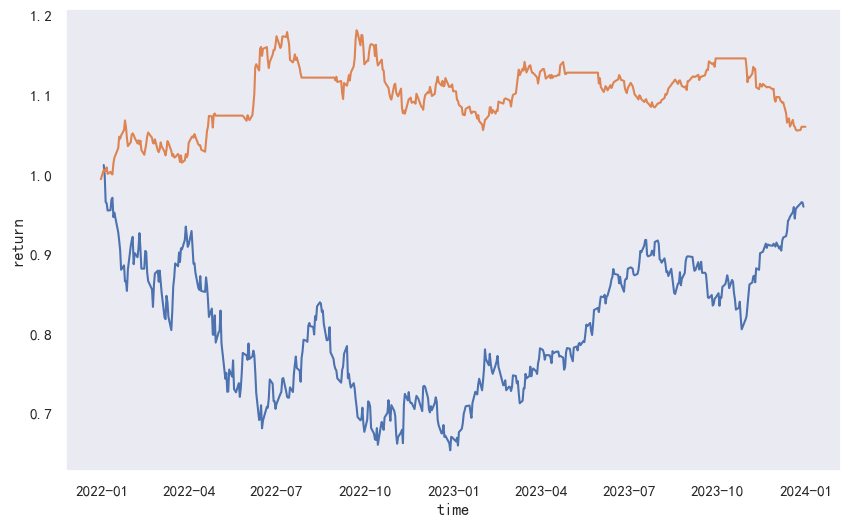

Sharpe:  0.3796315432931213
Drawdown: -0.10692661953130457
Annualized rate of return： 0.02916984081801277
Alpha:  0.029311996080531106  Beta:  -0.159987761852088
IR:  0.005773212611051644
Win rate: 0.5209580838323353


In [533]:
ret_SRHA=output_ret([S[-25:],H[-25:],A[-25:]],'opt1')
plot1(ret_SRHA,'SRHA')
print('Sharpe: ',sharpe_ratio_yearly(ret_SRHA))
print('Drawdown:',calculate_drawdown(ret_SRHA.values))
# alpha = calculate_alpha_with_factors(ret_SRHA.values, factors_data[-620:][:,3:4])
# print("Alpha:", alpha)
from sklearn.linear_model import LinearRegression

print('Annualized rate of return：',ret_SRHA[-1]**(250/len(ret_SRHA))-1)

# reg = LinearRegression().fit(factors_data[-620:][:,3:4].transpose().reshape(-1, 1),ret_SRHA.values)
# print('Beta: ',reg.coef_,'; Alpha: ',reg.intercept_ )
x,y = benchmark[(benchmark.index >= ret_SRHA.index[0]) &(benchmark.index <= ret_SRHA.index[-1])],ret_SRHA
y = y.reindex(x.index,method= 'ffill')
print('Alpha: ',cal_alpha(y)[0],' Beta: ',cal_alpha(y)[1])
print('IR: ', cal_IR(y))
print('Win rate:',cal_win_rate(y))

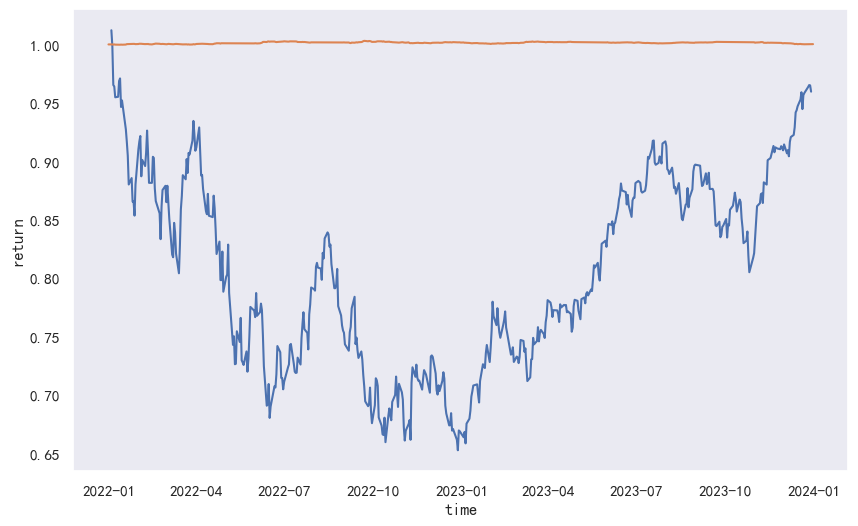

Sharpe:  0.06257354625307042
Drawdown: -0.0029078448381979595
Annualized rate of return： 8.171781547772206e-05
Alpha:  4.656221413837598e-05  Beta:  -0.003768566414344339
IR:  -0.0029969194116762415
Win rate: 0.49700598802395207


In [534]:
ret_SRHA=output_ret([S[-25:],H[-25:],A[-25:]],'get')
plot1(ret_SRHA,'SRHA')
print('Sharpe: ',sharpe_ratio_yearly(ret_SRHA))
print('Drawdown:',calculate_drawdown(ret_SRHA.values))
# alpha = calculate_alpha_with_factors(ret_SRHA.values, factors_data[-620:][:,3:4])
# print("Alpha:", alpha)
from sklearn.linear_model import LinearRegression

print('Annualized rate of return：',ret_SRHA[-1]**(250/len(ret_SRHA))-1)

# reg = LinearRegression().fit(factors_data[-620:][:,3:4].transpose().reshape(-1, 1),ret_SRHA.values)
# print('Beta: ',reg.coef_,'; Alpha: ',reg.intercept_ )
x,y = benchmark[(benchmark.index >= ret_SRHA.index[0]) &(benchmark.index <= ret_SRHA.index[-1])],ret_SRHA
y = y.reindex(x.index,method= 'ffill')
print('Alpha: ',cal_alpha(y)[0],' Beta: ',cal_alpha(y)[1])
print('IR: ', cal_IR(y))
print('Win rate:',cal_win_rate(y))